## **Weather Forecasting Module**

Fetch daily weather history via the free Open-Meteo API, turn it into a pandas DataFrame, and leave a clean hook for later modeling (AR/MA).

In [10]:
import requests
import pandas as pd
from datetime import date, timedelta

# Convenience: default to the last ~90 days if no dates are supplied later
DEFAULT_END = date.today()
DEFAULT_START = DEFAULT_END - timedelta(days=89)


In [2]:
def geocode_city(city: str) -> tuple[float, float]:
    """Return (lat, lon) for a city name using Open-Meteo's free geocoding API."""
    url = "https://geocoding-api.open-meteo.com/v1/search"
    resp = requests.get(url, params={"name": city, "count": 1, "language": "en"}, timeout=10)
    resp.raise_for_status()
    data = resp.json()
    results = data.get("results") or []
    if not results:
        raise ValueError(f"No geocoding results for '{city}'")
    lat = results[0]["latitude"]
    lon = results[0]["longitude"]
    return lat, lon


In [3]:
def fetch_weather_timeseries(city: str, start: date | None = None, end: date | None = None) -> pd.DataFrame:
    """
    Fetch daily weather history (avg/min/max temp, precip) for a city into a DataFrame.

    Uses Open-Meteo's archive API. Dates are inclusive and must be in YYYY-MM-DD.
    """
    start = start or DEFAULT_START
    end = end or DEFAULT_END
    if start > end:
        raise ValueError("start date must be <= end date")

    lat, lon = geocode_city(city)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start.isoformat(),
        "end_date": end.isoformat(),
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "precipitation_sum",
        ],
        "timezone": "auto",
    }

    resp = requests.get(url, params=params, timeout=20)
    resp.raise_for_status()
    data = resp.json()

    # Build DataFrame safely
    daily = data.get("daily", {})
    df = pd.DataFrame(daily)
    if df.empty:
        raise ValueError("No weather data returned; check dates or API availability")

    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df.rename(
        columns={
            "temperature_2m_max": "temp_max_c",
            "temperature_2m_min": "temp_min_c",
            "temperature_2m_mean": "temp_mean_c",
            "precipitation_sum": "precip_mm",
        },
        inplace=True,
    )
    return df


In [4]:
# Example: pull the last ~30 days for New York City
try:
    weather_df = fetch_weather_timeseries("New York")
    display(weather_df.head())
    display(weather_df.tail(3))
    print(f"Fetched {len(weather_df)} days spanning {weather_df.index.min().date()} to {weather_df.index.max().date()}")
except Exception as exc:
    print(f"Fetch failed: {exc}")


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2025-12-01,5.8,-1.3,2.7,0.0
2025-12-02,2.7,-1.8,0.8,17.2
2025-12-03,4.0,-1.5,0.8,0.0
2025-12-04,5.2,-4.7,0.2,0.1
2025-12-05,-1.0,-6.9,-3.6,0.0


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2025-12-08,1.5,-5.3,-2.3,0.0
2025-12-09,-0.4,-7.7,-3.9,0.0
2025-12-10,5.2,-0.3,2.1,2.3


Fetched 10 days spanning 2025-12-01 to 2025-12-10


### Next
- If you want a quick train/test split for AR/MA later: `train, test = weather_df.iloc[:-7], weather_df.iloc[-7:]`.
- You can resample to weekly averages with `weather_df.resample('W').mean()` if daily is too noisy.
- We'll add the stock fetching and a combined forecasting function next.


## AR/MA Weather Forecasting
We'll fit a simple ARIMA (AR + MA, no differencing) on a chosen weather metric, using the last 90–180 days as training and forecasting the next few days.


In [5]:
# Ensure statsmodels is available
try:
    from statsmodels.tsa.arima.model import ARIMA
except ImportError:  # Install on the fly if running in a fresh environment
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])
    from statsmodels.tsa.arima.model import ARIMA
import numpy as np


In [6]:
def prepare_series(df: pd.DataFrame, target_col: str = "temp_mean_c") -> pd.Series:
    """Return a daily-frequency Series with forward-filled gaps for modeling."""
    series = df[target_col].asfreq("D")
    series = series.ffill()
    return series


In [7]:
def weather_arima_forecast(
    city: str,
    target_col: str = "temp_mean_c",
    order: tuple[int, int, int] = (3, 0, 1),
    horizon: int = 7,
    start: date | None = None,
    end: date | None = None,
):
    """Fetch weather data, fit ARIMA(p,d,q), and forecast `horizon` days.

    - `order`: (p, d, q) where p=AR lags, d=differencing (0 for stationary), q=MA lags.
    - Adjust `start` to include enough history (>= ~2x horizon + p + q recommended).
    """
    df = fetch_weather_timeseries(city, start=start, end=end)
    series = prepare_series(df, target_col)

    if len(series) <= (horizon + order[0] + order[2]):
        raise ValueError("Not enough data to fit ARIMA with the requested order and horizon")

    train = series.iloc[:-horizon]
    test = series.iloc[-horizon:]

    model = ARIMA(
        train,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fitted = model.fit()
    forecast = fitted.forecast(steps=horizon)

    return {
        "data": df,
        "train": train,
        "test": test,
        "model": fitted,
        "forecast": forecast,
    }



In [8]:
def evaluate_forecast(test: pd.Series, forecast: pd.Series) -> dict:
    """Compute basic error metrics (MAE, MAPE)."""
    aligned = test.align(forecast, join="inner")
    test_aligned, forecast_aligned = aligned
    mae = (test_aligned - forecast_aligned).abs().mean()
    mape = ((test_aligned - forecast_aligned).abs() / test_aligned.replace(0, np.nan)).mean() * 100
    return {"mae": mae, "mape": mape}


In [ ]:
# Example run: forecast next 7 days of mean temperature for New York
# Use a full year of history for a more stable AR/MA fit.
example_start = date.today() - timedelta(days=365)

try:
    result = weather_arima_forecast(
        city="New York",
        target_col="temp_mean_c",
        order=(2, 1, 2),  # allow one differencing for smoother trends
        horizon=7,
        start=example_start,
        end=DEFAULT_END,
    )
    metrics = evaluate_forecast(result["test"], result["forecast"])
    print("Train samples:", len(result["train"]))
    print("Test horizon:", len(result["test"]))
    print("MAE (°C):", round(metrics["mae"], 2))
    print("MAPE (%):", round(metrics["mape"], 2))
    print("\nForecast vs actual (last few rows):")
    display(pd.DataFrame({
        "actual": result["test"],
        "forecast": result["forecast"],
    }))
except Exception as exc:
    print(f"Forecasting failed: {exc}")


Train samples: 174
Test horizon: 7
MAE (°C): 2.1
MAPE (%): 57.58

Forecast vs actual (last few rows):


/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,actual,forecast
2025-12-04,0.2,0.721077
2025-12-05,-3.6,0.456335
2025-12-06,0.3,0.053891
2025-12-07,1.3,-0.403023
2025-12-08,-2.3,-0.858790
2025-12-09,-3.9,-1.295647
2025-12-10,2.4,-1.718956


### Notes
- If metrics look poor, try a different `order`, e.g., `(2,0,2)` or add a seasonal differencing step for weekly patterns.
- Increase `start` history (e.g., 365 days) to stabilize AR/MA estimates.
- Swap `target_col` to `temp_max_c` or `precip_mm` to forecast other variables.
- Next: mirror this pattern for stocks, then wrap a single pipeline to choose weather vs stock.


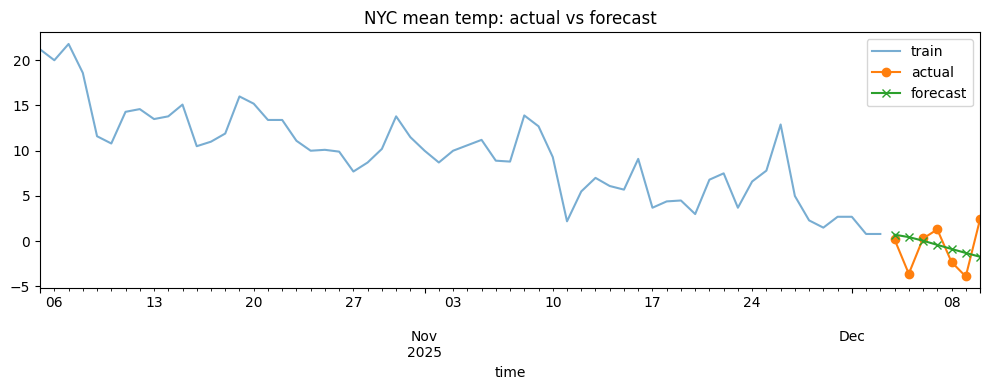

In [12]:
import matplotlib.pyplot as plt

def plot_forecast(train: pd.Series, test: pd.Series, forecast: pd.Series, title: str = "Forecast vs actual"):
    plt.figure(figsize=(10, 4))
    train.plot(label="train", alpha=0.6)
    test.plot(label="actual", marker="o")
    forecast.plot(label="forecast", marker="x")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize the last 60 days of training + test + forecast
try:
    plot_forecast(result["train"].iloc[-60:], result["test"], result["forecast"], title="NYC mean temp: actual vs forecast")
except Exception as exc:
    print(f"Plotting skipped: {exc}")


**If actuals and forecasts still seem far apart:**
- Ensure enough history: set `start = date.today() - timedelta(days=365)` or more.
- Try different orders: `(3,1,1)`, `(2,0,2)`, `(3,1,3)`; keep `d=1` if there's a trend.
- Reduce horizon (e.g., `horizon=3`) to make near-term predictions easier.
- Consider weekly seasonality: use SARIMA (p,d,q)x(P,D,Q,7) if you notice weekly patterns.
- Check data quality: if `temp_mean_c` has gaps, switch to `temp_max_c` or forward-fill longer (`series.ffill(limit=3)`).
